In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch import nn
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
from text_recognizer.datasets import EmnistDataset, EmnistLinesDataset, Transpose, construct_image_from_string, get_samples_by_character

In [3]:
emnist_lines = EmnistLinesDataset(train=False)

2020-08-30 21:31:37.785 | DEBUG    | text_recognizer.datasets.emnist_lines_dataset:_load_data:164 - EmnistLinesDataset loading data from HDF5...


In [4]:
def convert_y_label_to_string(y, emnist_lines=emnist_lines):
    return ''.join([emnist_lines.mapper(int(i)) for i in y])

office in Arkansas after the______
in________________________________
by a oneshot technique____________
office Incumbent__________________
of the revolutionary______________
they______________________________
the scene but_____________________
Knox Ky___________________________
workers wife refused to have______


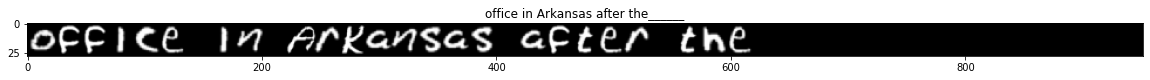

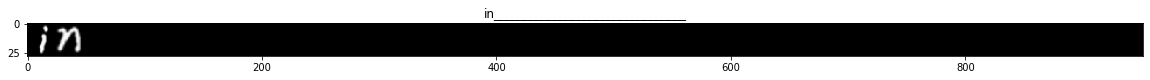

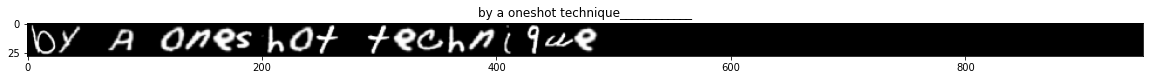

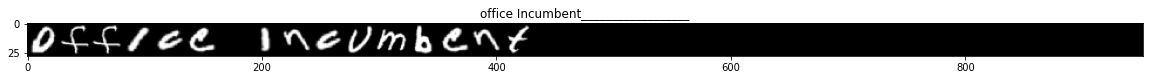

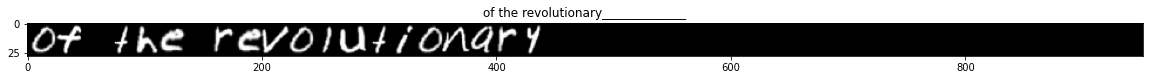

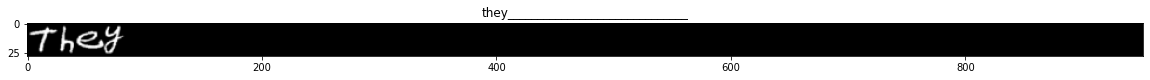

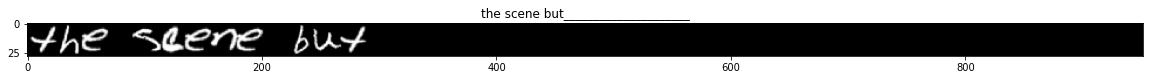

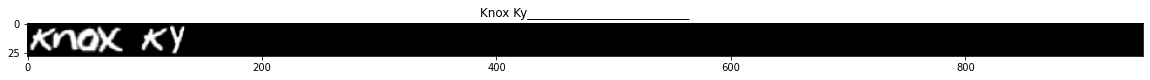

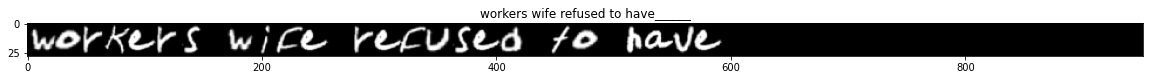

In [5]:
num_samples_to_plot = 9

for i in range(num_samples_to_plot):
    plt.figure(figsize=(20, 20))
    data, target = emnist_lines[i]
    sentence = convert_y_label_to_string(target.numpy()) 
    print(sentence)
    plt.title(sentence)
    plt.imshow(data.squeeze(0), cmap='gray')

In [7]:
from text_recognizer.networks.misc import sliding_window

In [8]:
data, target = emnist_lines[8]

In [12]:
patches = sliding_window(images=data.unsqueeze(0), patch_size=(28, 28), stride=(1, 14))

In [14]:
from einops.layers.torch import Rearrange
slide = nn.Sequential(nn.Unfold(kernel_size=(28, 28), stride=(1, 14)), Rearrange("b (c h w) t -> b t c h w", h=28, w=28, c=1))

In [15]:
slide(data.unsqueeze(0)).shape

torch.Size([1, 67, 1, 28, 28])

In [16]:
# remove batch size
patches = patches.squeeze(0)

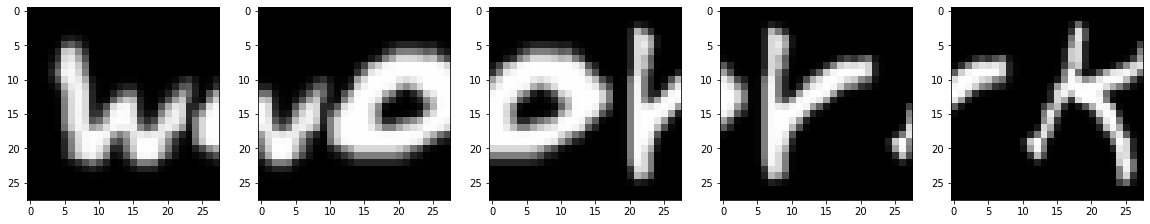

In [17]:
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(patches[i].squeeze(0), cmap='gray')

# Testing the data loader for EmnistLines

In [18]:
from text_recognizer.datasets.util import fetch_data_loaders

In [19]:
dls = fetch_data_loaders(["train"], "EmnistLinesDataset", {}, batch_size=2, shuffle=True, cuda=False)

2020-08-30 21:31:41.007 | DEBUG    | text_recognizer.datasets.emnist_lines_dataset:_load_data:164 - EmnistLinesDataset loading data from HDF5...


In [20]:
dl = dls["train"]

In [21]:
d, t = next(iter(dl))

In [25]:
patches = sliding_window(images=d, patch_size=(28, 28), stride=(1, 14))

might as well stand their_________


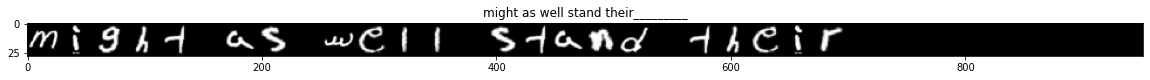

In [27]:
plt.figure(figsize=(20, 20))
sentence = convert_y_label_to_string(t[0].numpy()) 
print(sentence)
plt.title(sentence)
plt.imshow(d[0, 0], cmap='gray')
# plt.imshow(d[0, 0], cmap='gray')

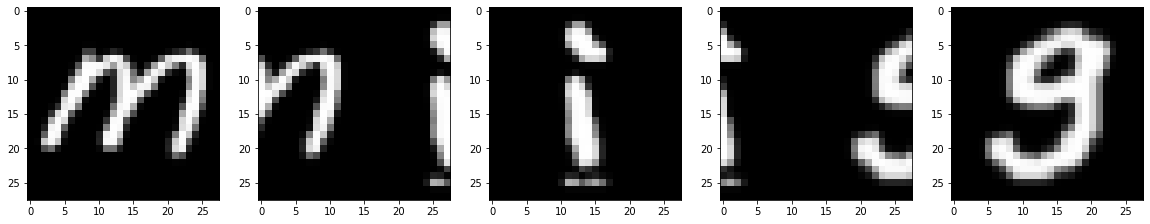

In [28]:
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(patches[0, i].squeeze(0), cmap='gray')